In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np


In [2]:
# Load the dataset
data = pd.read_csv('dataset.csv')

# Explore the dataset
#print(data.head())

C:\Users\naghmaaf\AppData\Local\Temp\ipykernel_7256\2562902205.py:2: DtypeWarning: Columns (3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('dataset.csv')


In [12]:
data.shape

# To make all the columns visible
pd.set_option('display.max_columns', None)


data.columns

data.dtypes

(data.isnull().sum()/data.shape[0])*100

id                 0.000000
spkid              0.000000
full_name          0.000000
pdes               0.000000
name              97.698128
prefix            99.998122
neo                0.000417
pha                2.078300
H                  0.653400
diameter          85.789714
albedo            85.905100
diameter_sigma    85.803068
orbit_id           0.000000
epoch              0.000000
epoch_mjd          0.000000
epoch_cal          0.000000
equinox            0.000000
e                  0.000000
a                  0.000000
q                  0.000000
i                  0.000000
om                 0.000000
w                  0.000000
ma                 0.000104
ad                 0.000417
n                  0.000000
tp                 0.000000
tp_cal             0.000000
per                0.000417
per_y              0.000104
moid               2.078300
moid_ld            0.013250
sigma_e            2.078404
sigma_a            2.078404
sigma_q            2.078404
sigma_i            2

In [39]:
# Near Earth Object
data.neo.value_counts()

#Orbit Id
print(data.orbit_id.unique())
data.orbit_id.nunique()

# Equinox
data.equinox.value_counts()

# Class
print(data['class'].unique())
data['class'].nunique()

# Output Label
data.pha.value_counts(normalize = True)

data_v1 = data.drop(columns = ['id','pdes', 'name', 'prefix', 'equinox'], axis = 'columns', inplace=False)
data_v1.shape

# Correlation of columns
data.corr()

data_corr = pd.DataFrame(data_v1.corr()>=0.99)

# Drop correlated columns
data_v1 = data_v1.drop(columns = ['epoch_mjd', 'epoch_cal', 'ad', 'tp_cal', 'per_y', 'sigma_ad', 'sigma_tp', 'sigma_ma'])

# Analysing missing pha
data_v1[data_v1.pha.isna()].isna().sum()

data_v2 = data_v1[data_v1.pha.notna()]
data_v2 = data_v2.drop(columns = ['diameter', 'albedo', 'diameter_sigma'])

data_v2.shape

# Impute null values in H column with mean
data_v2.H.fillna(np.mean(data_v2.H), inplace=True)

data_v2 = data_v2[data_v2.sigma_per.notna()]
data_v2 = data_v2[data_v2.ma.notna()]

data_v2.shape

# DATA PREPROCESSING

data_v2.head()

# orbit ID
print(data_v2.orbit_id.nunique())
orbits = data_v2.orbit_id.value_counts().loc[lambda x: x<20].index.to_list()

print(len(orbits))

data_v2.loc[data_v2.orbit_id.isin(orbits), 'orbit_id'] = 'other'

# Class
data['class'].nunique()

# Reset the index
data_v2 = data_v2.reset_index(drop=True)

# Normalizing the data
subset = data_v2[data_v2.columns[~data_v2.columns.isin(['spkid', 'full_name', 'neo', 'pha', 'orbit_id', 'class'])]]

from sklearn import preprocessing
normalize = preprocessing.MinMaxScaler()
scaled = normalize.fit_transform(subset)
scaled = pd.DataFrame(scaled, columns = subset.columns)
data_final = pd.concat([data_v2[['spkid', 'full_name', 'neo', 'pha', 'orbit_id', 'class']], scaled], axis=1)

data_v2.shape, data_final.shape

data_final.head(3)

#One hot encoding
data_final = pd.get_dummies(data_final, columns = ['neo',  'orbit_id', 'class'])

data_final.head(3)

data_final.shape

['JPL 47' 'JPL 37' 'JPL 112' ... 'E2020H77' 'E2020K86' 'E2020J48']
['MBA' 'OMB' 'MCA' 'AMO' 'IMB' 'TJN' 'CEN' 'APO' 'ATE' 'AST' 'TNO' 'IEO'
 'HYA']


C:\Users\naghmaaf\AppData\Local\Temp\ipykernel_7256\3830543671.py:22: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data.corr()
C:\Users\naghmaaf\AppData\Local\Temp\ipykernel_7256\3830543671.py:24: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data_corr = pd.DataFrame(data_v1.corr()>=0.99)


525
392


(938597, 174)

In [5]:
# ML MODEL

from sklearn.model_selection import train_test_split


X = data_final.drop(columns=['spkid', 'full_name', 'pha'])
Y = data_final['pha']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.01, random_state = 42)

# Checking if the data is imbalanced
data_final.pha.value_counts()/data_final.shape[0]

#Use SMOTE for oversampling the data because of High Imbalance
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state= 42)
X_train_res, Y_train_res = sm.fit_resample(X_train, Y_train.ravel())

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
def evaluation(Model):
    
    print("Accuracy: "+str(accuracy_score(Y_test, Model.predict(X_test))))
    print("Precision: "+str(precision_score(Y_test, Model.predict(X_test), average='macro')))    
    print("Recall: "+str(recall_score(Y_test, Model.predict(X_test), average = 'macro')))
    print("F1 Score: "+str(f1_score(Y_test, Model.predict(X_test), average = 'macro')))



In [67]:
data_final.columns

Index(['spkid', 'full_name', 'pha', 'H', 'epoch', 'e', 'a', 'q', 'i', 'om',
       ...
       'class_AST', 'class_ATE', 'class_CEN', 'class_IEO', 'class_IMB',
       'class_MBA', 'class_MCA', 'class_OMB', 'class_TJN', 'class_TNO'],
      dtype='object', length=174)

In [60]:
from sklearn.ensemble import RandomForestClassifier

RF = RandomForestClassifier(n_estimators=100, max_depth =5,min_samples_split = 10)

RF.fit(X_train, Y_train)

evaluation(RF)

Accuracy: 0.9985084167909652
Precision: 0.4992542083954826
Recall: 0.5
F1 Score: 0.49962682588762125


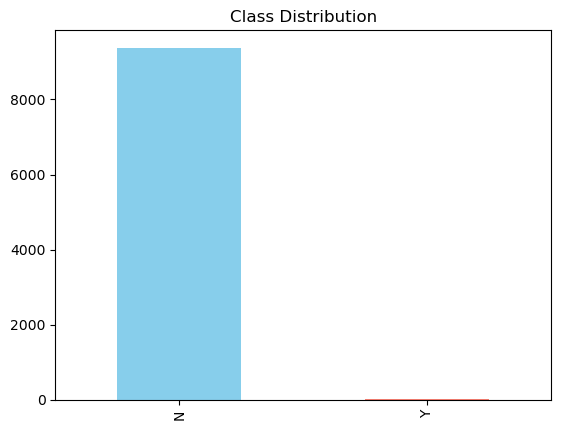

In [64]:
Y_test.value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title("Class Distribution")
plt.show()

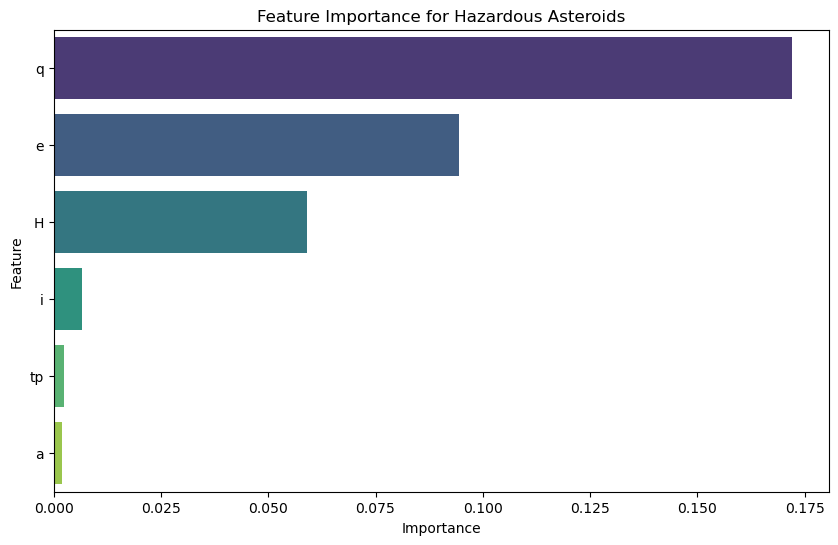

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns

# Train the Random Forest classifier
RF.fit(X_train_res, Y_train_res)

# Get feature importances
feature_importances = RF.feature_importances_

# Create a DataFrame with feature names and their importances
feature_importance_df = pd.DataFrame({'Feature': X_train_res.columns, 'Importance': feature_importances})

# Select features of interest
selected_features = ['H', 'e', 'i', 'tp', 'moid_ld', 'q','a']

# Filter the DataFrame to include only selected features
selected_feature_importance = feature_importance_df[feature_importance_df['Feature'].isin(selected_features)]

# Sort the DataFrame by importance in descending order
selected_feature_importance = selected_feature_importance.sort_values(by='Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=selected_feature_importance, palette='viridis')
plt.title('Feature Importance for Hazardous Asteroids')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


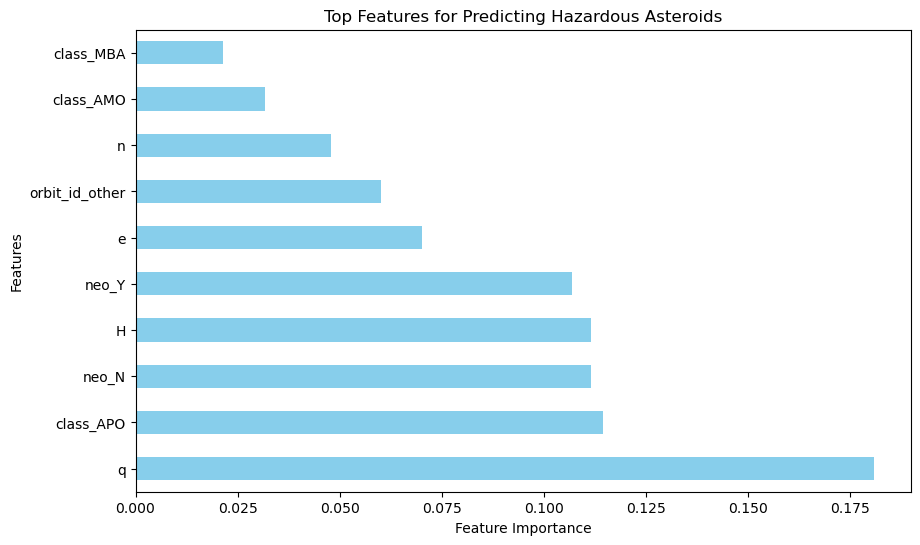

In [62]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming RF is your Random Forest Classifier model
feature_importances = pd.Series(RF.feature_importances_, index=X_train.columns)
top_features = feature_importances.nlargest(10)  # Adjust the number of features to display

# Plotting the top features
plt.figure(figsize=(10, 6))
top_features.plot(kind='barh', color='skyblue')
plt.title("Top Features for Predicting Hazardous Asteroids")
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.show()


Random Forest Confusion Matrix:
Accuracy: 0.9985084167909652
Precision: 0.4992542083954826
Recall: 0.5
F1 Score: 0.49962682588762125


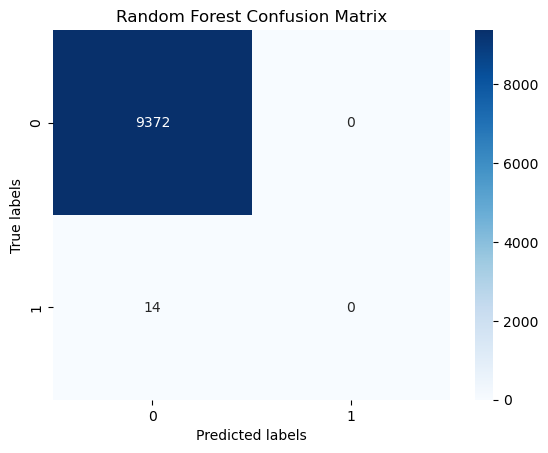

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import warnings
from sklearn.exceptions import UndefinedMetricWarning

def evaluation(Model):
    y_pred = Model.predict(X_test)
    
    print("Accuracy: " + str(accuracy_score(Y_test, y_pred)))
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=UndefinedMetricWarning)
        precision = precision_score(Y_test, y_pred, average='macro', zero_division=0)
        recall = recall_score(Y_test, y_pred, average='macro', zero_division=0)
        f1 = f1_score(Y_test, y_pred, average='macro', zero_division=0)

    print("Precision: " + str(precision))
    print("Recall: " + str(recall))
    print("F1 Score: " + str(f1))


# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', ax=ax)
    
    # Labels and title
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title(title)
    
    # Display the plot
    plt.show()

# Visualize Random Forest results
print("Random Forest Confusion Matrix:")
evaluation(RF)
y_pred_rf = RF.predict(X_test)
plot_confusion_matrix(Y_test, y_pred_rf, 'Random Forest Confusion Matrix')




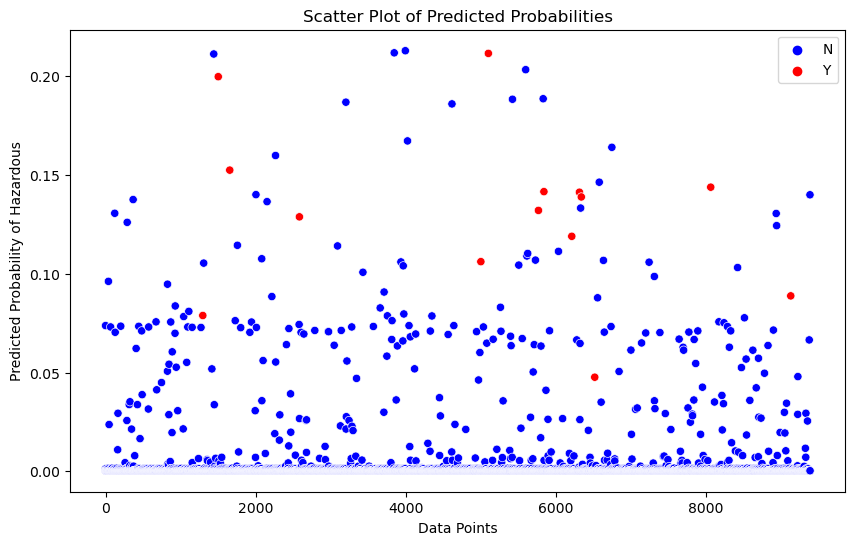

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc

# Assuming RF is your Random Forest Classifier model
RF.fit(X_train, Y_train)

# Get predicted probabilities
y_pred_proba = RF.predict_proba(X_test)[:, 1]

# Create a scatter plot
plt.figure(figsize=(10, 6))
palette = {'N': 'blue', 'Y': 'red'}  # Add keys for 'Y' and 'N'
sns.scatterplot(x=range(len(y_pred_proba)), y=y_pred_proba, hue=Y_test, palette=palette)

plt.xlabel('Data Points')
plt.ylabel('Predicted Probability of Hazardous')
plt.title('Scatter Plot of Predicted Probabilities')
plt.legend()
plt.show()


In [13]:
data.columns

Index(['id', 'spkid', 'full_name', 'pdes', 'name', 'prefix', 'neo', 'pha', 'H',
       'diameter', 'albedo', 'diameter_sigma', 'orbit_id', 'epoch',
       'epoch_mjd', 'epoch_cal', 'equinox', 'e', 'a', 'q', 'i', 'om', 'w',
       'ma', 'ad', 'n', 'tp', 'tp_cal', 'per', 'per_y', 'moid', 'moid_ld',
       'sigma_e', 'sigma_a', 'sigma_q', 'sigma_i', 'sigma_om', 'sigma_w',
       'sigma_ma', 'sigma_ad', 'sigma_n', 'sigma_tp', 'sigma_per', 'class',
       'rms'],
      dtype='object')

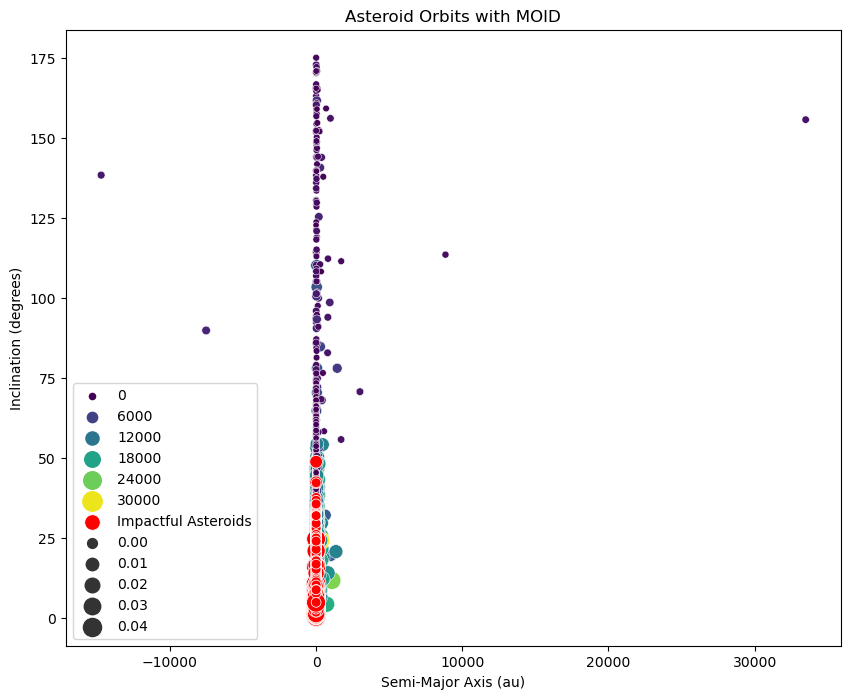

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df is your DataFrame containing asteroid data
# and 'moid_ld' is the Minimum Orbit Intersection Distance in au
df = data
# Select relevant columns
asteroid_data = df[['a', 'i', 'moid_ld']]

# Create a scatter plot with MOID as the color and size
plt.figure(figsize=(10, 8))
sns.scatterplot(x='a', y='i', hue='moid_ld', size='moid_ld', sizes=(20, 200), data=asteroid_data, palette='viridis')

# Highlight impactful asteroids with red color
impactful_asteroids = asteroid_data[asteroid_data['moid_ld'] < 0.05]
sns.scatterplot(x='a', y='i', color='red', size='moid_ld', sizes=(50, 200), data=impactful_asteroids, label='Impactful Asteroids')

plt.xlabel('Semi-Major Axis (au)')
plt.ylabel('Inclination (degrees)')
plt.title('Asteroid Orbits with MOID')
plt.legend()
plt.show()


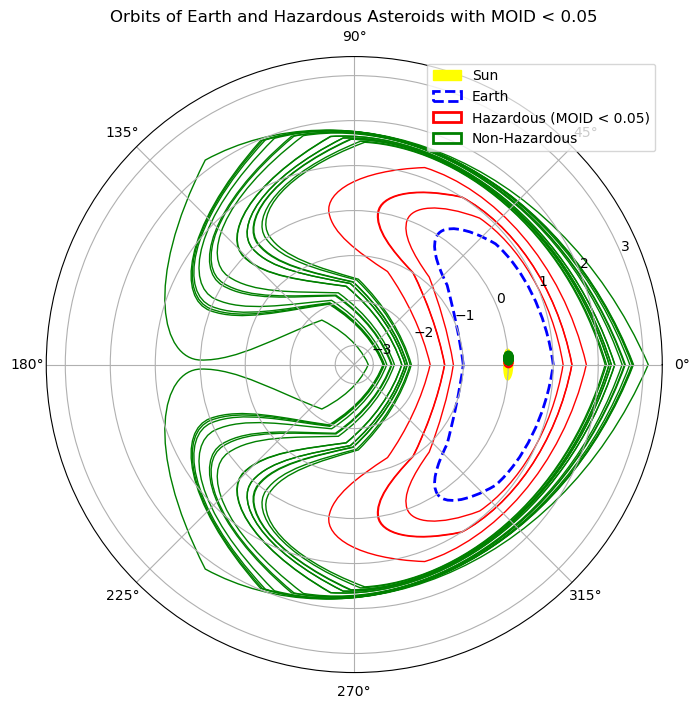

Selected Asteroids:
               a  pha         e   moid_ld
89958   1.735703    Y  0.528384  0.010335
163131  1.219649    Y  0.295260  0.011179
177048  1.417434    Y  0.614141  0.043045
292219  1.412352    Y  0.312184  0.025597
545163  2.245953  NaN  0.233075  0.000000
545222  2.585657  NaN  0.353036  0.000000
545234  2.290446  NaN  0.130933  0.000000
545251  2.368927  NaN  0.168986  0.000000
545272  2.366254  NaN  0.140570  0.000000
545274  2.181819  NaN  0.153173  0.000000
545289  2.154793  NaN  0.212590  0.000000
545295  2.754252  NaN  0.184880  0.000000
545322  2.241171  NaN  0.083893  0.000000
545326  2.530894  NaN  0.114118  0.000000
545333  2.771030  NaN  0.104668  0.000000
545372  2.701217  NaN  0.228171  0.000000
545380  2.290312  NaN  0.150881  0.000000
545381  3.112152  NaN  0.170915  0.000000
545390  2.600665  NaN  0.216056  0.000000
545395  2.783440  NaN  0.169374  0.000000


In [58]:
import numpy as np
import matplotlib.pyplot as plt

# Function to plot circular Earth-like shape
def plot_earth(ax):
    earth_orbit = plt.Circle((0, 0), 1, color='blue', fill=False, linestyle='dashed', linewidth=2)
    ax.add_patch(earth_orbit)

# Function to plot orbits of hazardous asteroids with perihelion and aphelion markers
def plot_asteroid_orbits(ax, asteroid_data, num_asteroids, moid_threshold):
    filtered_asteroids = asteroid_data[asteroid_data['moid_ld'] < moid_threshold].head(num_asteroids)

    for index, row in filtered_asteroids.iterrows():
        is_hazardous = row['pha'] == 'Y'
        color = 'red' if is_hazardous else 'green'
        orbit_radius = row['a']  # Assuming 'a' is the semi-major axis of the orbit

        # Calculate perihelion and aphelion points
        perihelion = orbit_radius * (1 - row['e'])
        aphelion = orbit_radius * (1 + row['e'])

        # Plot the orbit
        orbit = plt.Circle((0, 0), orbit_radius, color=color, fill=False, linestyle='solid', linewidth=1)
        ax.add_patch(orbit)

        # Plot perihelion and aphelion markers
        ax.plot(np.radians([perihelion, aphelion]), [0, 0], marker='o', color=color)

    return filtered_asteroids

# Example data (replace this with your actual DataFrame containing asteroid data)
# Assuming df is your DataFrame containing asteroid data
# 'a' is the semi-major axis, 'pha' indicates whether the asteroid is hazardous,
# 'e' is the eccentricity, and 'moid_ld' is the Minimum Orbit Intersection Distance in au
example_data = df[['a', 'pha', 'e', 'moid_ld']]

# Set your desired MOID threshold and number of asteroids
moid_threshold = 0.05
num_asteroids = 20

# Create a plot
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': 'polar'})

# Plot Earth's orbit
plot_earth(ax)

# Plot orbits of hazardous asteroids with perihelion and aphelion markers
selected_asteroids = plot_asteroid_orbits(ax, example_data, num_asteroids, moid_threshold)

# Plot the Sun at the center
sun = plt.Circle((0, 0), 0.1, color='yellow', fill=True)
ax.add_patch(sun)

# Set aspect ratio to be equal, so circles appear as circles
ax.set_aspect('equal', adjustable='box')

# Add legends for Earth, Hazardous, Non-Hazardous, and Sun orbits
legend_labels = ['Sun','Earth', 'Hazardous (MOID < {})'.format(moid_threshold), 'Non-Hazardous']
legend_handles = [plt.Circle((0, 0), 0.1, color='yellow', fill=True),
                  plt.Circle((0, 0), 1, color='blue', fill=False, linestyle='dashed', linewidth=2),
                  plt.Circle((0, 0), 1, color='red', fill=False, linestyle='solid', linewidth=2),
                  plt.Circle((0, 0), 1, color='green', fill=False, linestyle='solid', linewidth=2),
                  ]

ax.legend(handles=legend_handles, labels=legend_labels, loc='upper right')

# Set title
plt.title('Orbits of Earth and Hazardous Asteroids with MOID < {}'.format(moid_threshold))

# Show the plot
plt.show()

# Display the information of the selected asteroids
print("Selected Asteroids:")
print(selected_asteroids)


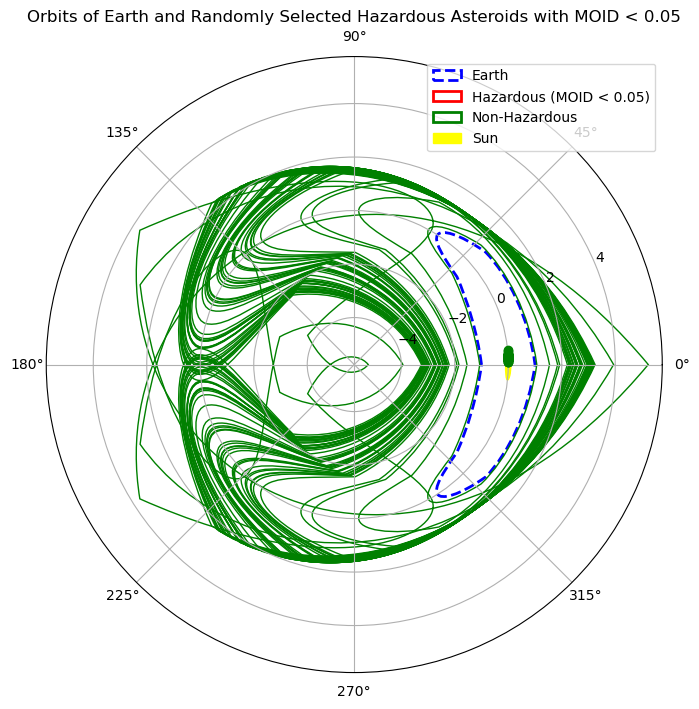

Selected Asteroids:
               a  pha         e      moid_ld
458652  3.244544    N  0.213758   604.295393
200309  3.141247    N  0.073296   747.319259
128853  3.030858    N  0.214124   547.947468
821163  2.560156    N  0.125960   489.564185
925669  2.435218    N  0.258889   326.300754
153958  2.740994    N  0.200152   467.280311
293657  2.446425    N  0.177800   387.766653
563302  2.583064    N  0.384258   253.706539
126790  2.426829    N  0.142580   416.326283
625849  3.029530    N  0.045882   743.629928
187284  2.518770    N  0.194833   400.790616
941209  1.067703    N  0.015627    23.503222
554218  2.983101    N  0.026971   742.793212
291874  2.209861    N  0.201263   295.055073
215636  2.322303    N  0.136161   391.851381
524545  3.176957    N  0.155961   683.709423
853150  3.084051  NaN  0.093518     0.000000
873465  3.151514    N  0.163821   650.299178
360599  2.556725    N  0.109802   509.236728
947221  3.100496    N  0.205723   570.499870
830366  3.183761    N  0.187520   6

In [56]:
import numpy as np
import matplotlib.pyplot as plt

# Function to plot circular Earth-like shape
def plot_earth(ax):
    earth_orbit = plt.Circle((0, 0), 1, color='blue', fill=False, linestyle='dashed', linewidth=2)
    ax.add_patch(earth_orbit)

# Function to plot orbits of hazardous asteroids with perihelion and aphelion markers
def plot_asteroid_orbits(ax, asteroid_data, num_asteroids, moid_threshold):
    # Randomly select num_asteroids from the dataset
    filtered_asteroids = asteroid_data.sample(n=num_asteroids)

    for index, row in filtered_asteroids.iterrows():
        is_hazardous = row['pha'] == 'Y'
        color = 'red' if is_hazardous else 'green'
        orbit_radius = row['a']  # Assuming 'a' is the semi-major axis of the orbit

        # Calculate perihelion and aphelion points
        perihelion = orbit_radius * (1 - row['e'])
        aphelion = orbit_radius * (1 + row['e'])

        # Plot the orbit
        orbit = plt.Circle((0, 0), orbit_radius, color=color, fill=False, linestyle='solid', linewidth=1)
        ax.add_patch(orbit)

        # Plot perihelion and aphelion markers
        ax.plot(np.radians([perihelion, aphelion]), [0, 0], marker='o', color=color)

    return filtered_asteroids

# Example data (replace this with your actual DataFrame containing asteroid data)
# Assuming df is your DataFrame containing asteroid data
# 'a' is the semi-major axis, 'pha' indicates whether the asteroid is hazardous,
# 'e' is the eccentricity, and 'moid_ld' is the Minimum Orbit Intersection Distance in au
example_data = df[['a', 'pha', 'e', 'moid_ld']]

# Set your desired MOID threshold and number of asteroids
moid_threshold = 0.05
num_asteroids = 50

# Create a plot
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': 'polar'})

# Plot Earth's orbit
plot_earth(ax)

# Plot orbits of hazardous asteroids with perihelion and aphelion markers
selected_asteroids = plot_asteroid_orbits(ax, example_data, num_asteroids, moid_threshold)

# Plot the Sun at the center
sun = plt.Circle((0, 0), 0.1, color='yellow', fill=True)
ax.add_patch(sun)

# Set aspect ratio to be equal, so circles appear as circles
ax.set_aspect('equal', adjustable='box')

# Add legends for Earth, Hazardous, Non-Hazardous, and Sun orbits
legend_labels = ['Earth', 'Hazardous (MOID < {})'.format(moid_threshold), 'Non-Hazardous', 'Sun']
legend_handles = [plt.Circle((0, 0), 1, color='blue', fill=False, linestyle='dashed', linewidth=2),
                  plt.Circle((0, 0), 1, color='red', fill=False, linestyle='solid', linewidth=2),
                  plt.Circle((0, 0), 1, color='green', fill=False, linestyle='solid', linewidth=2),
                  plt.Circle((0, 0), 0.1, color='yellow', fill=True)]

ax.legend(handles=legend_handles, labels=legend_labels, loc='upper right')

# Set title
plt.title('Orbits of Earth and Randomly Selected Hazardous Asteroids with MOID < {}'.format(moid_threshold))

# Show the plot
plt.show()

# Display the information of the selected asteroids
print("Selected Asteroids:")
print(selected_asteroids)
